# "[CNN] VGG"
> "이미지 분류하기 & 전이학습"

- toc: true
- branch: master
- badges: true
- comments: true
- categories: [DL, Pytorch, CNN, VGG]
- author: 도형준

# 이미지 분류하기

In [1]:
import matplotlib.pyplot as plt

from torchvision.datasets.cifar import CIFAR10 # 10가지 클래스를 가지는 이미지 데이터셋 ex. 자동차, 동물 등
from torchvision.transforms import ToTensor

## 데이터 적재

In [2]:
# CIFAR10 데이터셋을 불러오기
training_data = CIFAR10(
    root="./", 
    train=True, 
    download=True, 
    transform=ToTensor())

test_data = CIFAR10(
    root="./", 
    train=False, 
    download=True, 
    transform=ToTensor())

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified


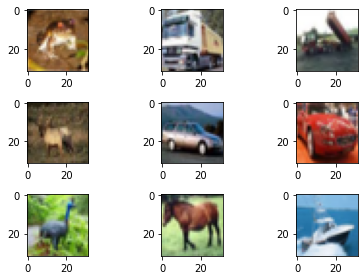

In [3]:
for i in range(9):
   plt.subplot(3, 3, i+1)
   plt.imshow(training_data.data[i])

plt.tight_layout()
plt.show()

## 이미지 데이터 전처리

In [4]:
# 데이터 증강: 이미지에 여러 변형을 주어서 이미지 개수를 늘리는 방법
# 회전, 크기 변경, 밀림, 반사, 이동 등
# 오버피팅 방지를 위해서, 이미지에 변화를 주어 데이터셋 크기를 늘리는 방법

### 크롭핑(Cropping)

In [5]:
import matplotlib.pyplot as plt
import torchvision.transforms as T

from torchvision.datasets.cifar import CIFAR10
from torchvision.transforms import Compose
from torchvision.transforms import RandomHorizontalFlip, RandomCrop

In [6]:
transforms = Compose([ # 어떤 순서대로 이미지를 처리할 것인지
    T.ToPILImage(),
    RandomCrop((32,32),padding = 4), # 랜덤으로 이미지를 일부 제거하고 padding(특정값으로 채우기)
    RandomHorizontalFlip(p=0.5)
])

Files already downloaded and verified
Files already downloaded and verified


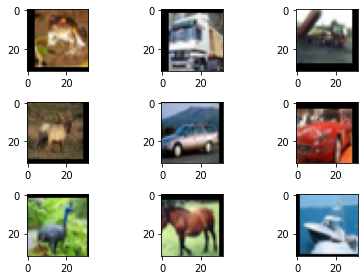

In [7]:
training_data = CIFAR10(
    root="./", 
    train=True, 
    download=True, 
    transform=transforms) # 크롭핑 적용

test_data = CIFAR10(
    root="./", 
    train=False, 
    download=True, 
    transform=transforms) # 크롭핑 적용

for i in range(9):
   plt.subplot(3, 3, i+1)
   plt.imshow(transforms(training_data.data[i])) # 크롭핑 적용

plt.tight_layout()
plt.show()

### 이미지 정규화

In [8]:
from torchvision.transforms import Normalize
transforms = Compose([
        T.ToPILImage(),
        RandomCrop((32, 32), padding=4),
        RandomHorizontalFlip(p=0.5),
        T.ToTensor(),
        Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261)), # 가장 많이 쓰이는 RGB의 평균과 분산
        T.ToPILImage()
        ])

Files already downloaded and verified
Files already downloaded and verified


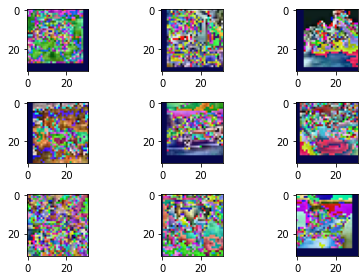

In [9]:
training_data = CIFAR10(
    root='./',
    train=True,
    download=True,
    transform=transforms
)
test_data = CIFAR10(
    root='./',
    train=False,
    download=True,
    transform=transforms
)
# 샘플 데이터 보기
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(transforms(training_data.data[i]))
plt.tight_layout()
plt.show()

In [10]:
import torch

# 이미지 데이터셋의 평균과 표준편차
training_data = CIFAR10(
    root='./',
    train=True,
    download=True,
    transform=ToTensor()
)

# 0 : 이미지 / 1 : 분류에서 정답 (레이블)
imgs = [item[0] for item in training_data]
imgs = torch.stack(imgs, dim=0).numpy()

Files already downloaded and verified


In [11]:
imgs.shape # Size, Channel(RGB), Height, Weight,

(50000, 3, 32, 32)

In [12]:
# mean=(0.4914, 0.4822, 0.4465)
mean_r = imgs[:,0,:,:].mean()
mean_g = imgs[:,1,:,:].mean()
mean_b = imgs[:,2,:,:].mean()
print(mean_r, mean_g, mean_b)

0.49139968 0.48215827 0.44653124


In [13]:
# std=(0.247, 0.243, 0.261)
mean_r = imgs[:,0,:,:].std()
mean_g = imgs[:,1,:,:].mean()
mean_b = imgs[:,2,:,:].mean()
print(mean_r, mean_g, mean_b)

0.24703233 0.48215827 0.44653124


## 모델 정의

1. **nn.Sequential()**
  - 순서대로 층을 쌓아서 모델 구축
  - Customizing X
  - **간단한 신경망 구조**를 구현할 때만 사용
2. **nn.Module()**
  - **복잡한 신경망**
  - 여러가지 특징을 추출
  - 여러 층을 추가
---

- 학습 루프 => (    ) 블록(학습 루프 내부에서 학습할 방식을 선언하는 구간)

- **입력 => 합성곱(3X3) => ReLU => 합성곱(3x3) => ReLu => (맥스 or 평균)풀링 => 출력**
---

### 기본 블록 정의

In [14]:
# 기본 블록 정의
import torch
import torch.nn as nn

In [15]:
# 클래스를 사용하는 이유: 상속을 위해서
# 같은 포맷을 받아서 -> 그 안에 활용
class BasicBlock(nn.Module):
    # 기본 블록 구성하는 기본 정의
    def __init__(self, in_channels, out_channels, hidden_dim):
        # nn.Module
        super(BasicBlock, self).__init__()
        # 합성곱 층
        # in_channels : 입력 채널 수
        # kernel_size : 커널의 크기
        # padding : 이미지 외곽을 둘러쌀 0의 개수
        self.conv1 = nn.Conv2d(in_channels, hidden_dim,
                               kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(hidden_dim, out_channels,
                               kernel_size=3, padding=1)
        self.relu = nn.ReLU()

        # 커널의 이동 거리 stride
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    
    # 순전파 정의
    def forward(self, x):
        x = self.conv1(x) # 합성곱1을 지나고
        x = self.relu(x) # 활성화함수를 지나고
        x = self.conv2(x) # 합성곱2를 지나고
        x = self.relu(x) # 활성화함수
        x = self.pool(x) # 맥스풀링을 지난걸
        return x # 리턴

### CNN 모델

In [16]:
class CNN(nn.Module):
    def __init__(self, num_classes): # 클래스 개수
        super(CNN, self).__init__()

        # 합성곱 기본 블록 정의
        self.block1 = BasicBlock(in_channels=3, out_channels=32, hidden_dim=16)
        self.block2 = BasicBlock(in_channels=32, out_channels=128, hidden_dim=64)
        self.block3 = BasicBlock(in_channels=128, out_channels=256, hidden_dim=128)

        # 분류기
        self.fc1 = nn.Linear(in_features=4096, out_features=2048)
        self.fc2 = nn.Linear(in_features=2048, out_features=256)
        self.fc3 = nn.Linear(in_features=256, out_features=num_classes)

        # 분류기의 활성화 함수
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x) # 출력 모양 (-1, 256, 4, 4)
        x = torch.flatten(x, start_dim=1)
        
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)

        return x

In [17]:
from torch.utils.data.dataloader import DataLoader
from torch.optim.adam import Adam

transforms = Compose([
    RandomCrop((32, 32), padding=4), # 랜덤 크롭핑
    RandomHorizontalFlip(p=0.5), # 1/2 확률로 y축 뒤집기
    ToTensor(), # 텐서 변환
    Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261))
])

In [18]:
# 학습용/평가용 데이터 불러오기
training_data = CIFAR10(
    root="./", 
    train=True, 
    download=True, 
    transform=transforms)

test_data = CIFAR10(
    root="./", 
    train=False, 
    download=True, 
    transform=transforms)

# 데이터로더 정의(batch_size)
train_loader = DataLoader(training_data,batch_size=(32),shuffle = True)
test_loader = DataLoader(test_data,batch_size=(32),shuffle = False)

# device = cpu or gpu(cuda)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# CNN 모델 정의 (<= CNN 클래스 불러오기(객체 선언))
model = CNN(num_classes=10)

# 모델을 device로
model.to(device)

Files already downloaded and verified
Files already downloaded and verified


CNN(
  (block1): BasicBlock(
    (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): BasicBlock(
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): BasicBlock(
    (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=4096, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=256,

In [19]:
lr = 1e-3 # 학습률 정의

# 최적화 기법 정의 (adam)
optim = Adam(model.parameters(), lr=lr)

# 학습 루프 정의
for epoch in range(100):
    for data, label in train_loader: # 데이터 호출
        optim.zero_grad() # 기울기 초기화
        preds = model(data.to(device))
        # 분류 문제 (회귀 문제면 MSE)
        loss = nn.CrossEntropyLoss()(preds, label.to(device))
        loss.backward() # 오차 역전파
        optim.step() # 최적화
    
    if epoch==0 or epoch%10==9:
        print(f"epoch{epoch+1} loss:{loss.item()}")

torch.save(model.state_dict(), "CIFAR.pth")

epoch1 loss:1.609474778175354
epoch10 loss:0.7288380861282349
epoch20 loss:1.027662754058838
epoch30 loss:0.6513725519180298
epoch40 loss:0.751952052116394
epoch50 loss:0.9881114959716797
epoch60 loss:0.7497033476829529
epoch70 loss:0.9025692939758301
epoch80 loss:0.39072442054748535
epoch90 loss:0.14546874165534973
epoch100 loss:2.3025853633880615


In [21]:
model.load_state_dict(torch.load('CIFAR.pth', map_location=device))
num_corr = 0
with torch.no_grad():
    for data, label in test_loader:
        output = model(data.to(device))
        preds = output.data.max(1)[1]
        corr = preds.eq(label.to(device).data).sum().item()
        num_corr += corr
    print(f"Accuracy : {num_corr/len(test_data)}")

Accuracy : 0.1


## 전이학습 모델 VGG를 이용한 분류와 비교

In [22]:
from torchvision.models.vgg import vgg16

model = vgg16(pretrained=True)
# 분류기 <- vgg16 이미 학습된 데이터를 통해 만들어진 모델
# 10개를 분류 <- 커스터마이징
fc = nn.Sequential(
    nn.Linear(512 * 7 * 7, 4096),
    nn.ReLU(),
    nn.Dropout(), # 오버피팅
    nn.Linear(4096, 4096),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(4096, 10),
)

model.classifier = fc
model.to(device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
# 데이터 전처리, 증강 
# 데이터 로더 정의
# 학습루프 정의
# 모델 성능 평가

from torchvision.transforms import Resize

transforms = Compose([
    # 전이학습한 모델 224
    Resize(224),
    RandomCrop((224, 224), padding=4), # 랜덤 크롭핑
    RandomHorizontalFlip(p=0.5), # 1/2 확률로 y축 뒤집기
    ToTensor(), # 텐서 변환
    Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261))
])

# 학습용/평가용 데이터 불러오기
training_data = CIFAR10(root='./', train=True, download=True, transform=transforms)
test_data = CIFAR10(root='./', train=False, download=True, transform=transforms)

# 데이터로더 정의 (batch size)
train_loader = DataLoader(training_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

lr = 1e-4 # 학습률 정의

# 최적화 기법 정의 (adam)
optim = Adam(model.parameters(), lr=lr)

import tqdm

# 학습 루프 정의
for epoch in range(30):
    iterator = tqdm.tqdm(train_loader)
    for data, label in iterator: # 데이터 호출
        optim.zero_grad() # 기울기 초기화
        preds = model(data.to(device))
        # 분류 문제 (회귀 문제면 MSE)
        loss = nn.CrossEntropyLoss()(preds, label.to(device))
        loss.backward() # 오차 역전파
        optim.step() # 최적화
    
    if epoch==0 or epoch%10==9:
        print(f"epoch{epoch+1} loss:{loss.item()}")

torch.save(model.state_dict(), "CIFAR_pretrained.pth")

Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 1563/1563 [12:05<00:00,  2.15it/s]


epoch1 loss:0.05225498229265213


 25%|██▌       | 393/1563 [03:01<09:03,  2.15it/s]

In [ ]:
model.load_state_dict(torch.load('CIFAR_pretrained.pth', map_location=device))
num_corr = 0
with torch.no_grad():
    for data, label in test_loader:
        output = model(data.to(device))
        preds = output.data.max(1)[1]
        corr = preds.eq(label.to(device).data).sum().item()
        num_corr += corr
    print(f"Accuracy : {num_corr/len(test_data)}")